In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

# from scipy import stats
# from tabulate import tabulate
# import sklearn
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
# from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
# from yellowbrick.cluster import KElbowVisualizer
# from scipy.cluster.hierarchy import dendrogram, linkage

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


In [3]:
df_name = []
encoding = []
path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    df_name.append(file_name)
    print(f"{file_name}: {result}")

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


In [4]:
data_source = (tuple(df_name), tuple(encoding), tuple(path))

In [5]:
context = pd.read_csv(data_source[2][0], encoding=data_source[1][0])
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
7007,15251,Work,Al%o&ne,Sunn?y,7:00,1,1,0,0,1,0,0
11495,8624,Travel,~ %!Friend(s),Su~n?ny,22:00,1,1,0,0,1,0,0
5711,6173,Travel,F%r&i~en d(s),Su&n&ny,16:00,1,0,0,0,1,4,0
2604,9392,Visit,!A %lone,~!S~!unny,21:00,1,1,1,0,1,0,0
9717,18313,Work,~%%~Alone,Rainy,7:00,1,1,1,0,1,0,0


In [6]:
mobile_plan_attr = pd.read_csv(
    data_source[2][1], encoding=data_source[1][1], delimiter=";"
)

mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
1,DATAGOLD,"5GB/ day, high speed",200000,5d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
0,DATASILVER,"2GB/ day, high speed",100000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d


In [7]:
mobile_plan_user = pd.read_csv(data_source[2][2], encoding=data_source[1][2])
mobile_plan_user.sample(5)

,id,mobile_plan,accept
1292,17699.0,DATAGOLD,1.0
36884,16060.0,DATASILVER,1.0
21843,13942.0,DATAGOLD,0.0
29503,18260.0,DATACALL,0.0
45137,7560.0,SOCIALMEDIAGOLD,0.0


In [8]:
user = pd.read_csv(data_source[2][3], encoding=data_source[1][3])
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
9581,16391,Ing. Willfried Bonbach B.Sc.,Male,24,Bachelor,Business & Financial,72800$,Unma r ried_0,DENMARK,03754 83472,Schornsteinfeger,7,2,6,1,0
11255,11217,Lisa Ward,Female,25,Bachelor,Unemployed,1227500000 VND,M arr ied_1,US,+1-561-502-4038x2711,Soil scientist,0,0,1,2,0
4099,1857,Ronnie Villanueva,Male,21,NaN,Sales & Related,55200$,Unmarried_0,US,(403)243-5572x0119,"Development worker, community",0,0,3,7,2
10678,4292,Tamara Davenport,Female,27,Bachelor,Community & Social Services,48200$,U nma rried_0,ENGLAND,(878)505-9837,Personnel officer,0,0,3,0,0
4460,18010,Angela Thomas,Female,62,NaN,Personal Care & Service,94900$,Married_1,ENGLAND,(837)247-5785,"Conservation officer, historic buildings",0,20,0,2,1


In [9]:
dataset = [context, mobile_plan_attr, mobile_plan_user, user]

# Cleaning

## Missing values check


In [10]:
for x in dataset:
  print('-----------------')
  print(x.isna().sum())

-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64


In [11]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

## Duplicate

In [12]:
user['id'].duplicated().sum()

0

In [13]:
context['id'].duplicated().sum()

0

In [14]:
mobile_plan_user.sort_values(by='id').head()

,id,mobile_plan,accept
18023,1000.0,SOCIALMEDIA,0.0
18022,1000.0,DATACALL,0.0
18021,1000.0,DATASILVER,0.0
3014,1000.0,DATASILVER,1.0
3087,1001.0,SOCIALMEDIA,1.0


## Context


In [15]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
3087,1001,Work,&A ~lone,&S%u%nny,7AM,1,0,0,1,0,8,1
7861,17795,Visit,A% &&lone,Su&?!nny,4 PM,1,0,0,0,1,5,0
3006,12158,Work,Alon e,Su&&nny,7:00,1,0,0,1,0,0,1
6522,16784,Visit,Al&one,Sunny,17:00,1,0,0,0,1,9,0
6130,16200,Travel,Friend(s),Sunny,7 PM,1,1,0,0,1,0,0


In [16]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()

    print(context[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [17]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)

In [18]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M").dt.time

In [19]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

In [20]:
context.purpose.unique()

array(['travel', 'visit', 'work'], dtype=object)

In [21]:
context["purpose"] = context["purpose"].replace('travel', 'visit')

In [22]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])

In [23]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,score,direction
880,15942,visit,family,sunny,13:00:00,1,0,0,0,0
2548,3405,work,alone,sunny,06:00:00,1,0,0,0,1
9872,8109,work,alone,sunny,06:00:00,1,0,0,0,1
3079,6138,visit,family,sunny,09:00:00,1,1,0,0,0
8918,12711,visit,alone,sunny,17:00:00,1,1,1,7,0


## User


In [24]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
4650,19594,Ethan Hunter,Male,29,Bachelor,Computer & Mathematical,61100$,M arri ed_3,AUSTRALIA,0466.856.157,Horticultural therapist,0,2,1,3,1
5165,3733,Елизавета Ивановна Рыбакова,Female,24,Associate,Sales & Related,34200$,S i ngle_0,RUSSIA,+7 452 530 0635,Связист,8,2,5,2,1
3679,14214,Самсонов Артем Иосифович,Male,31,NaN,Sales & Related,72500$,Un ma rried_0,RUSSIA,+79930833198,Иммунолог,19,2,3,8,1
8518,9667,Gernot van der Dussen,Male,24,Bachelor,Student,1382500000 VND,Si ngle_0,DENMARK,+49(0) 793064899,Krankenschwester,0,0,8,0,0
8396,5718,Shawn Harper MD,Male,23,Highschool,Student,1197500000 VND,Single_0,ENGLAND,780.678.3680,"Embryologist, clinical",1,0,0,0,0


In [25]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

In [26]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

In [27]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

In [28]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

In [29]:
user.nation.unique()

array(['australia', 'england', 'korea', 'denmark', 'brazil', 'japan',
       'us', 'china', 'russia'], dtype=object)

In [30]:
user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

In [31]:
user = user.rename(columns={"nation": "continent"})

In [32]:
currency_exchange_rate = 23000

# Function to clean and adjust income values
def clean_income(value):
    if 'VND' in value:
        return int(value.replace('VND', '')) / currency_exchange_rate
    elif '$' in value:
        return int(value.replace('$', ''))
    else:
        return int(value)

# Apply the function to the 'income' column
user['income_1'] = user['income'].apply(clean_income)

In [33]:
user['profession'] = user['profession'].str.lower()

In [34]:
user['profession'] = user['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

In [35]:
user.head()

,id,name,gender,age,education,profession,income,living_with,continent,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_1
0,11156,Rachel Gibbs,female,21,NaN,unemployed,39100$,unmarried_2,oceania,(08)-8012-7556,Astronomer,0,0,9,8,3,39100.000000
1,4297,Karen Anderson,other,22,NaN,unemployed,41000$,unmarried_2,europe,943-646-5203,Air cabin crew,0,0,23,7,2,41000.000000
2,13301,김지원,female,24,NaN,unemployed,44300$,unmarried_1,asia,010-4500-9888,기계공학 기술자 및 연구원,0,0,23,5,2,44300.000000
3,9920,Elisabeth Wähner,female,24,NaN,unemployed,44400$,unmarried_1,europe,+49(0) 587406963,Medizininformatiker,0,0,21,7,2,44400.000000
4,8424,Sra. Maria Luiza Nogueira,female,25,NaN,unemployed,1100000000 VND,unmarried_1,americas,(084) 0568 1445,Ufólogo,0,0,22,5,3,47826.086957


In [36]:
user["education"] = user["education"].fillna("unknown")
user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")

In [37]:
user.profession.unique()

array(['unemployed', 'jobs', 'student', 'retired'], dtype=object)

In [38]:
user.living_with.unique()

array(['unmarried_2', 'unmarried_1', 'single_0', 'married_1', 'married_2',
       'married_4', 'married_3', 'unmarried_0', 'single_2', 'single_1',
       'single_4', 'single_3', 'divorced_2', 'divorced_1', 'divorced_3',
       'married_0', 'unmarried_4', 'divorced_4', 'widowed_0',
       'unmarried_3', 'widowed_4', 'widowed_1', 'widowed_3', 'widowed_2',
       'divorced_0'], dtype=object)

In [39]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

## mobile_plan_attr


In [40]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration
0,DATASILVER,"2GB/ day, high speed",100000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d


In [41]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()

In [42]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')

In [43]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')

In [44]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [45]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [46]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()

In [47]:
mobile_planes = mobile_plan_user.mobile_plan.unique()

### Mobile plan recommendation


In [48]:
mobile_plan_rec_raw = mobile_plan_user[["id"]]

# Create columns for each item in the mobile_plan_user dataframe
for item in mobile_planes:
    mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
        lambda x: 1 if x == item else np.nan
    )

# Check rows that have duplicated ID
duplicate_rows = mobile_plan_rec_raw[
    mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
]
# Sort by ID
duplicate_rows.sort_values("id")

# Fill missing values of each ID group
# In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
mobile_plan_rec = duplicate_rows.groupby("id").apply(
    lambda x: x.fillna(method="ffill").fillna(method="bfill")
)
mobile_plan_rec = mobile_plan_rec.drop_duplicates()

mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

mobile_plan_rec = mobile_plan_rec.fillna(0)
mobile_plan_rec

,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,1.0,0.0,1.0,1.0,0.0
1,1001.0,0.0,0.0,1.0,1.0,0.0
2,1005.0,0.0,0.0,1.0,1.0,1.0
3,1006.0,0.0,0.0,1.0,1.0,0.0
4,1008.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
10107,19992.0,0.0,1.0,1.0,1.0,0.0
10108,19996.0,0.0,1.0,1.0,1.0,1.0
10109,19997.0,1.0,1.0,0.0,0.0,1.0
10110,19998.0,1.0,1.0,1.0,0.0,0.0


### Mobile plan conversion rate

In [49]:
mobile_plan_accept = mobile_plan_user.pivot_table(
index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
).reset_index()

# Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
for plan in mobile_planes:
  if plan not in mobile_plan_accept.columns:
    mobile_plan_accept[plan] = 0

# Sắp xếp lại các cột theo thứ tự trong mobile_planes
mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [50]:
# Sử dụng pivot_table để tổng hợp dữ liệu
num_rec = mobile_plan_user.pivot_table(
    index="id", columns="mobile_plan", values="mobile_plan", aggfunc="count", fill_value=0
).reset_index()

# Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
for plan in mobile_planes:
    if plan not in num_rec.columns:
        num_rec[plan] = 0

# Sắp xếp lại các cột theo thứ tự trong mobile_planes
num_rec = num_rec[["id"] + list(mobile_planes)]

# Đảm bảo rằng cả hai bảng đều có cùng thứ tự cột
assert list(mobile_plan_accept.columns) == list(num_rec.columns)

# Tạo bảng mobile_plan_cr bằng cách chia mobile_plan_accept cho num_rec
mobile_plan_cr = mobile_plan_accept.copy()

# Tính tỷ lệ chuyển đổi (conversion rate)
for plan in mobile_planes:
    mobile_plan_cr[plan] = mobile_plan_accept[plan] / num_rec[plan]

mobile_plan_cr.fillna(0, inplace=True)

# Hiển thị bảng mobile_plan_cr
mobile_plan_cr

mobile_plan,id,datasilver,socialmediagold,socialmedia,datacall,datagold
0,1000.0,0.5,0.0,0.0,0.0,0.0
1,1001.0,0.0,0.0,0.5,0.0,0.0
2,1002.0,0.0,1.0,0.0,0.0,0.0
3,1004.0,0.0,0.0,0.0,0.0,0.0
4,1005.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
11567,19994.0,0.0,0.0,0.0,0.0,0.0
11568,19996.0,0.0,0.0,0.0,1.0,0.0
11569,19997.0,1.0,0.0,0.0,0.0,0.0
11570,19998.0,0.0,0.0,0.0,0.0,0.0


# Data type check


In [51]:
dataset = [context, mobile_plan_attr, mobile_plan_cr, mobile_plan_rec, user]
for x in dataset:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
time            object
viettel_no_0     int64
viettel_no_1     int64
viettel_no_2     int64
score            int64
direction        int64
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
mobile_plan
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           float64
dtype: object
-------------------------
id                 float64
datasilver         float64
socialmediagold    float64
socialmedia        float64
datacall           float64
datagold           float64
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             

In [52]:
context.time = pd.to_datetime(context.time, format="%H:%M:%S").dt.time


mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


mobile_plan_cr.id = mobile_plan_cr.id.astype(int)
mobile_plan_cr.datasilver = mobile_plan_cr.datasilver.astype(int)
mobile_plan_cr.socialmediagold = mobile_plan_cr.socialmediagold.astype(int)
mobile_plan_cr.socialmedia = mobile_plan_cr.socialmedia.astype(int)
mobile_plan_cr.datacall = mobile_plan_cr.datacall.astype(int)
mobile_plan_cr.datagold = mobile_plan_cr.datagold.astype(int)


mobile_plan_rec.id = mobile_plan_rec.id.astype(int)
mobile_plan_rec.datasilver = mobile_plan_rec.datasilver.astype(int)
mobile_plan_rec.socialmediagold = mobile_plan_rec.socialmediagold.astype(int)
mobile_plan_rec.socialmedia = mobile_plan_rec.socialmedia.astype(int)
mobile_plan_rec.datacall = mobile_plan_rec.datacall.astype(int)
mobile_plan_rec.datagold = mobile_plan_rec.datagold.astype(int)


user.children = user.children.astype(int)
user.income_1 = user.income_1.astype(int)

## Merge

In [53]:
df = (
  user.merge(context, on="id", how="left")
  .merge(mobile_plan_rec, on="id", how="left", suffixes=("", "_rec"))
  .merge(mobile_plan_cr, on="id", how="left", suffixes=("", "_cr"))
)

df.isna().sum()

id                       0
name                     0
gender                   0
age                      0
education                0
profession               0
income                   0
living_with              0
continent                0
phone                    0
job                      0
fb_freq                  0
yt_freq                  0
insta_freq               0
use_less_than_2GB        0
use_2GB_to_4GB           0
income_1                 0
marital_status           0
children                 0
purpose                  0
go_with                  0
weather                  0
time                     0
viettel_no_0             0
viettel_no_1             0
viettel_no_2             0
score                    0
direction                0
datasilver            1460
socialmediagold       1460
socialmedia           1460
datacall              1460
datagold              1460
datasilver_cr            0
socialmediagold_cr       0
socialmedia_cr           0
datacall_cr              0
d

In [54]:
df = df.dropna()

## Outliers

In [55]:
df.columns

Index(['id', 'name', 'gender', 'age', 'education', 'profession', 'income',
       'living_with', 'continent', 'phone', 'job', 'fb_freq', 'yt_freq',
       'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'income_1',
       'marital_status', 'children', 'purpose', 'go_with', 'weather', 'time',
       'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction',
       'datasilver', 'socialmediagold', 'socialmedia', 'datacall', 'datagold',
       'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr',
       'datagold_cr'],
      dtype='object')

In [56]:
df = df[['gender', 'age', 'education', 'profession', 'income_1', 'continent',
       
       'fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',
       
       'marital_status', 'children', 'purpose', 'go_with', 'weather', 'time',
       
       'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction',
       
       'datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall',
       
       'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr',
       'datagold_cr']]

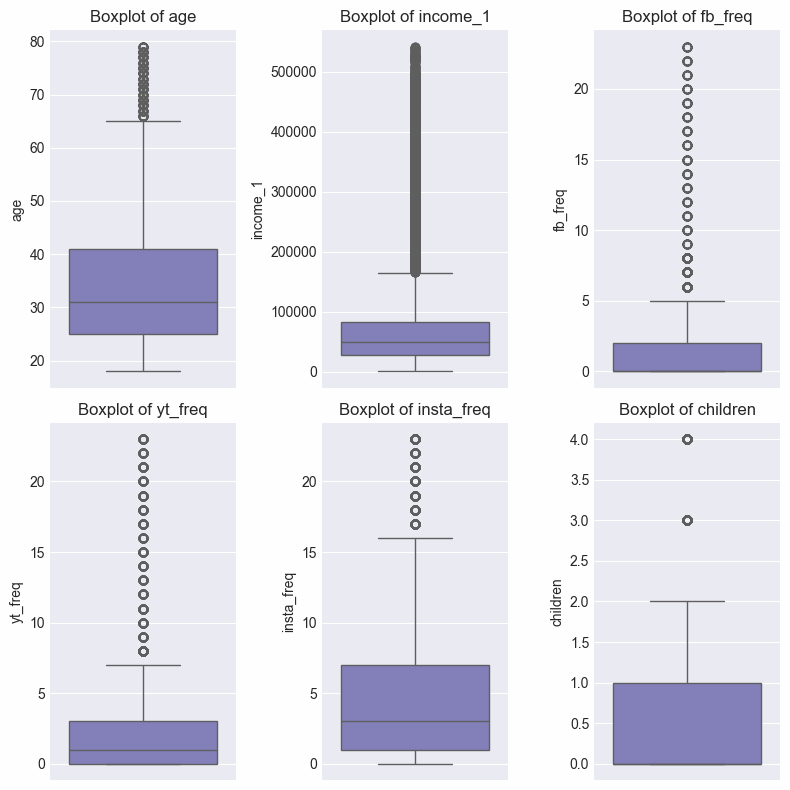

In [57]:
categorical_columns = ['gender', 'education', 'profession', 'continent', 'marital_status', 'purpose', 'go_with', 'weather', 'time', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction', 'datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall', 'datasilver_cr', 'socialmediagold_cr', 'socialmedia_cr', 'datacall_cr', 'datagold_cr', 'use_less_than_2GB','use_2GB_to_4GB']

continuous_columns = df.drop(axis=1, columns=categorical_columns).columns

# Create a canvas with 4 columns and 4 rows
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

# Draw boxplot on the canvas
for i, ax in enumerate(axes.flatten()):
    if i < len(continuous_columns):
        sns.boxplot(y=continuous_columns[i], data=df, ax=ax)
        ax.set_title(f'Boxplot of {continuous_columns[i]}')
        ax.set_ylabel(continuous_columns[i])
    else:
        ax.axis('off')

# Fit layout
plt.tight_layout()

plt.show()

### Income

In [58]:
Q1 = df['income_1'].quantile(0.25)
Q3 = df['income_1'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df = df[(df['income_1'] >= lower_bound) & (df['income_1'] <= upper_bound)]

(array([595., 748., 948., 984., 960., 878., 862., 793., 434., 414., 446.,
        438., 229.,  43.,  33.,  33.,  16.,  23.,  29.,  20.,  31.,  28.,
         20.,  24.,  33.,  19.,  29.,  28.,  29.,  26.]),
 array([  1000.,   9220.,  17440.,  25660.,  33880.,  42100.,  50320.,
         58540.,  66760.,  74980.,  83200.,  91420.,  99640., 107860.,
        116080., 124300., 132520., 140740., 148960., 157180., 165400.,
        173620., 181840., 190060., 198280., 206500., 214720., 222940.,
        231160., 239380., 247600.]),
 <BarContainer object of 30 artists>)

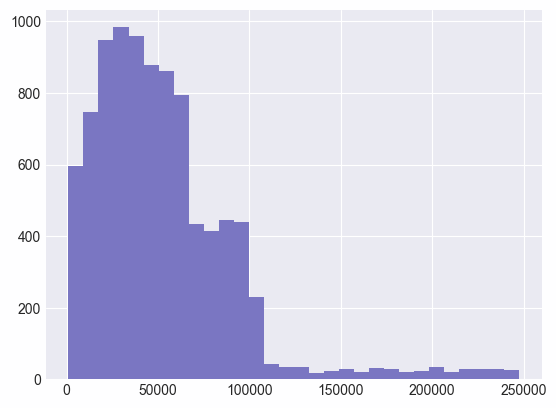

In [59]:
plt.hist(df['income_1'], bins=30)

### Age

In [60]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

----------------

In [64]:
labels = ['datasilver', 'datagold', 'socialmedia', 'socialmediagold', 'datacall']

In [65]:
features = df.drop(axis=1, columns=labels)

In [66]:
#Check categorical variables
check = (features.dtypes == 'object')
object_columns = list(check[check].index)

object_columns

['gender',
 'education',
 'profession',
 'continent',
 'marital_status',
 'purpose',
 'go_with',
 'weather',
 'time']

# EDA
## Univariate

In [71]:
class EDA:
    
    def row(self,data):
        # Display the number of rows and columns in the dataframe
        fig = make_subplots(rows=1, cols=2)
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[0], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🧾 Rows<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
        fig.add_trace(go.Indicator(mode = "number", value = data.shape[1], number={'font':{'color': '#E58F65','size':100}}, title = {"text": "⭕ Columns<br><span style='font-size:0.8em;color:gray'>In the Dataframe</span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
        fig.show()
    
    def border_msg(self,msg, indent=1, width=None, title=None):
        """Print message-box with optional title."""
        lines = msg.split('\n')
        space = " " * indent
        if not width:
            width = max(map(len, lines))
        box = f'╔{"═" * (width + indent * 2)}╗\n'  
        if title:
            box += f'║{space}{title:<{width}}{space}║\n'  
            box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  
        box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
        box += f'╚{"═" * (width + indent * 2)}╝' 
        print('\033[92m'+'\033[1m')
        print(box)
        
    def distribution(self,x,title):
        # Plot the distribution of a numerical column
        plt.figure(figsize=(10,8))
        ax = sns.distplot(x, kde=False,bins=30)
        values = np.array([rec.get_height() for rec in ax.patches])
        norm = plt.Normalize(values.min(), values.max())
        colors = plt.cm.jet(norm(values))
        for rec, col in zip(ax.patches,colors):
            rec.set_color(col)
        plt.title(title, size=20, color='black')
        
    def run(self,df):
        
        self.row(df)
        if len(df)>0:
            
            object_df = df.select_dtypes('object').columns.tolist()
            int_df = df.select_dtypes('int').columns.tolist()
            bool_df = df.select_dtypes('bool').columns.tolist()
            float_df = df.select_dtypes('float').columns.tolist()

            if len(object_df)>0:
                
                print( '\033[1m'+"OBJECT TYPE")
                for col in object_df:
                    # Display information about object type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('There are {} unique values in {} column'.format(df[col].nunique(),col.upper()))
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(int_df)>0:
                
                print('\033[1m'+"INT TYPE")
                for col in int_df:
                    # Display information about integer type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    self.border_msg('Average value is : {}'.format(df[col].mean()))
                    self.border_msg('Minumum value is : {}'.format(df[col].min()))
                    self.border_msg('Maximum value is : {}'.format(df[col].max()))
                    self.distribution(df[col],title=col)
                    if df[col].mean()>df[col].std():
                        print(self.border_msg("Normal distributed Data Located below mean"))
                        
                    elif df[col].mean()<df[col].std():
                        print(self.border_msg("Normal distributed Data Located above mean"))
                    else:
                        self.border_msg("Mean Equals Std Dev - Distribution is normal")
                        
                    fig = make_subplots(rows=1, cols=2)
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].mean(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "📌 Mean<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0, 0.5], 'y': [0.6, 1]}))
                    fig.add_trace(go.Indicator(mode = "number", value = df[col].std(), number={'font':{'color': '#E58F65','size':100}}, title = {"text": "🖇 Standart dev<br><span style='font-size:0.8em;color:gray'></span>"}, domain = {'x': [0.5, 1], 'y': [0, 0.4]}))
                    fig.show()
                    plt.show()
                 

            if len(bool_df)>0:
                
                print('\033[1m'+"BOOL TYPE")
                for col in bool_df:
                    # Display information about boolean type columns
                    self.border_msg(' '*25+ col.upper() + ' '*25)
                    plt.figure(figsize=(10,5))
                    sns.countplot(y = col, data = df,
                                  order = df[col].value_counts().index)
                    plt.show()
                    
            if len(float_df)>0:
                
                print('\033[1m'+"FLOAT TYPE")
                for col in float_df:
                    # Display information about float type columns
                    for col in int_df:
                        self.distribution(df[col],title=col)
                        if df[col].mean()>df[col].std():
                            print(self.border_msg("Normal distributed Data Located below mean"))
                        
                        elif df[col].mean()<df[col].std():
                            print(self.border_msg("Normal distributed Data Located above mean"))
                        else:
                            self.border_msg("Mean Equals Std Dev - Distribution is normal")

OBJECT TYPE

╔══════════════════════════════════════════════════════════╗
║                          GENDER                          ║
╚══════════════════════════════════════════════════════════╝

╔════════════════════════════════════════════╗
║ There are 3 unique values in GENDER column ║
╚════════════════════════════════════════════╝


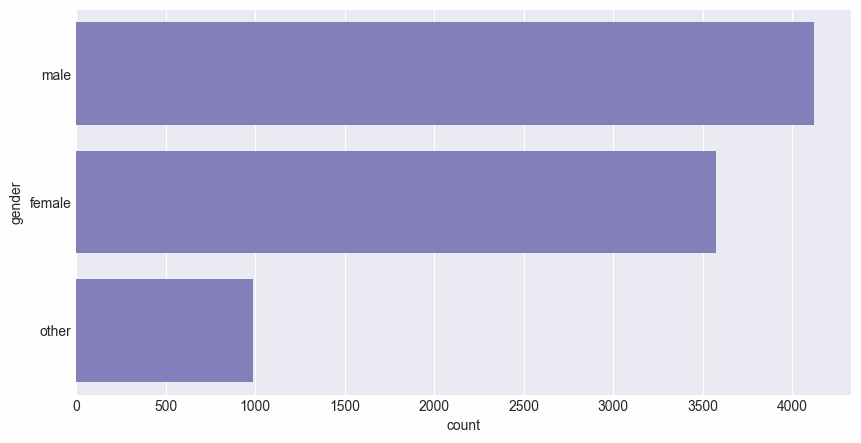


╔═════════════════════════════════════════════════════════════╗
║                          EDUCATION                          ║
╚═════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════╗
║ There are 4 unique values in EDUCATION column ║
╚═══════════════════════════════════════════════╝


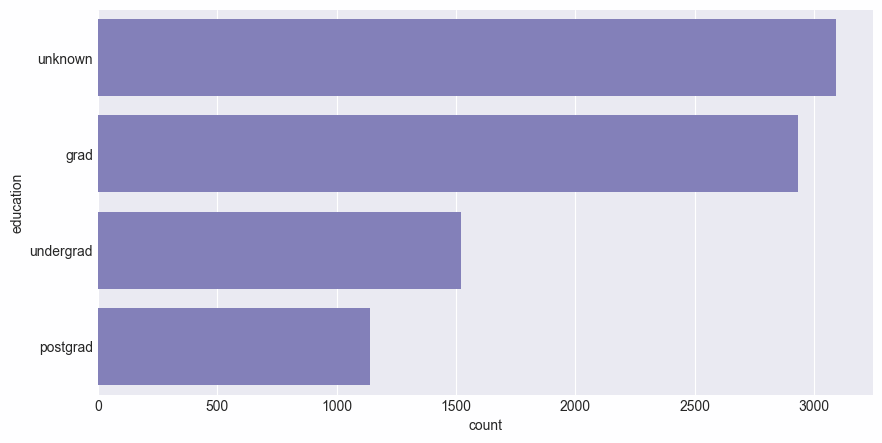


╔══════════════════════════════════════════════════════════════╗
║                          PROFESSION                          ║
╚══════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════════════╗
║ There are 4 unique values in PROFESSION column ║
╚════════════════════════════════════════════════╝


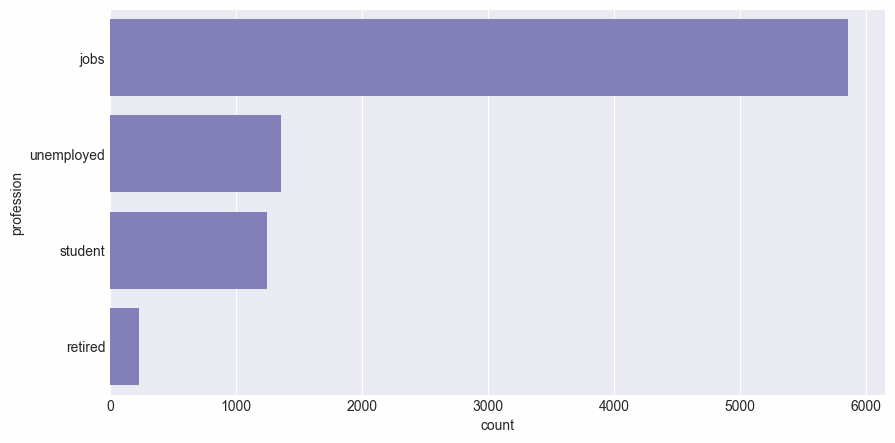


╔═════════════════════════════════════════════════════════════╗
║                          CONTINENT                          ║
╚═════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════╗
║ There are 4 unique values in CONTINENT column ║
╚═══════════════════════════════════════════════╝


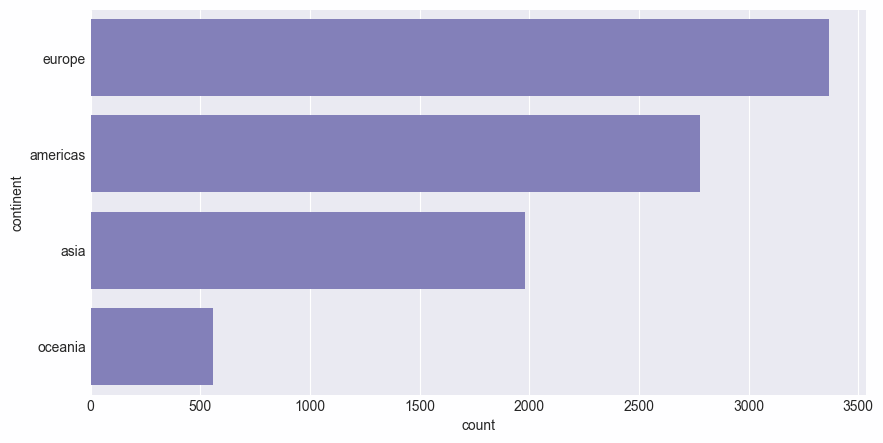


╔══════════════════════════════════════════════════════════════════╗
║                          MARITAL_STATUS                          ║
╚══════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════════════════╗
║ There are 2 unique values in MARITAL_STATUS column ║
╚════════════════════════════════════════════════════╝


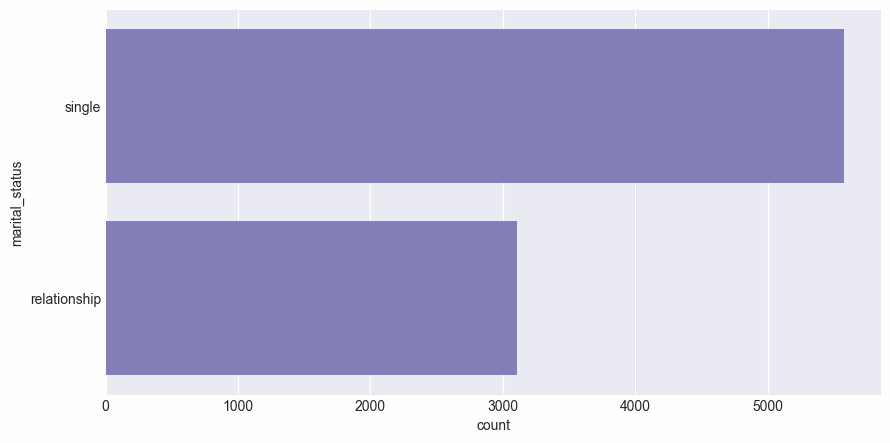


╔═══════════════════════════════════════════════════════════╗
║                          PURPOSE                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 2 unique values in PURPOSE column ║
╚═════════════════════════════════════════════╝


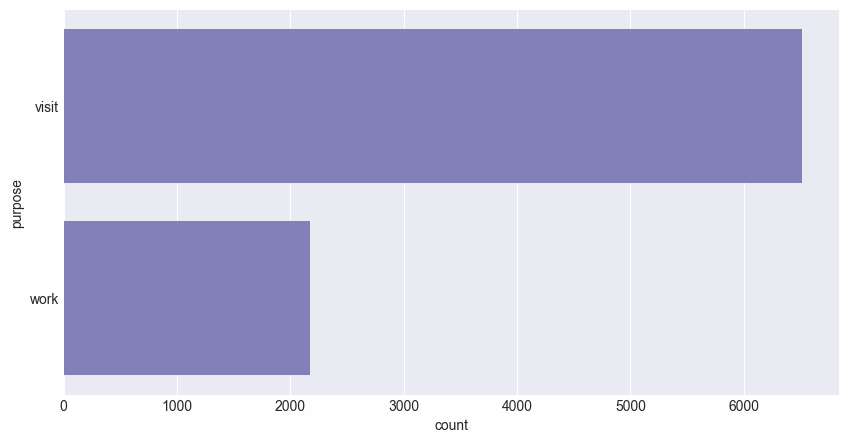


╔═══════════════════════════════════════════════════════════╗
║                          GO_WITH                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 3 unique values in GO_WITH column ║
╚═════════════════════════════════════════════╝


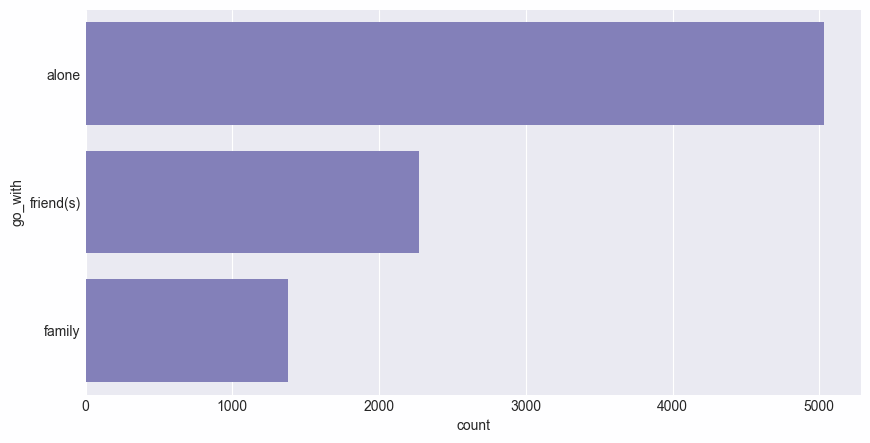


╔═══════════════════════════════════════════════════════════╗
║                          WEATHER                          ║
╚═══════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════╗
║ There are 3 unique values in WEATHER column ║
╚═════════════════════════════════════════════╝


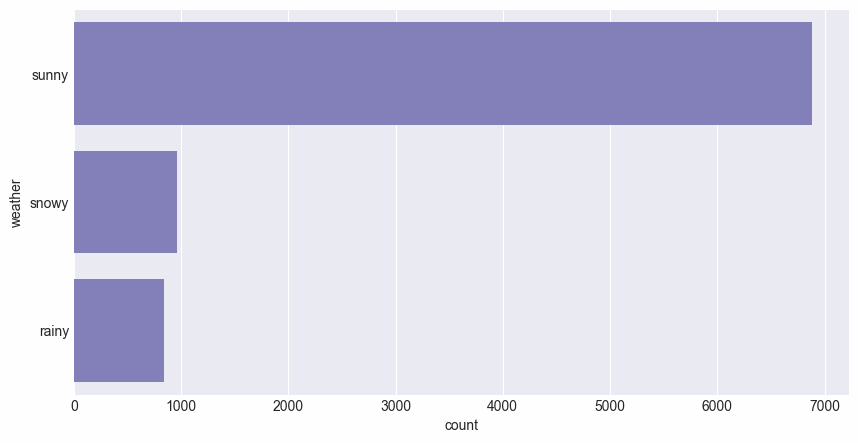


╔════════════════════════════════════════════════════════╗
║                          TIME                          ║
╚════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════╗
║ There are 18 unique values in TIME column ║
╚═══════════════════════════════════════════╝


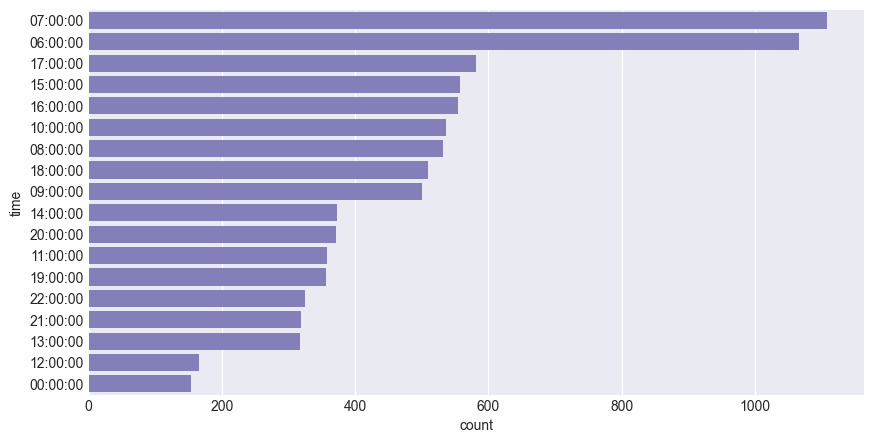

INT TYPE

╔═══════════════════════════════════════════════════════╗
║                          AGE                          ║
╚═══════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 32.50230255583698 ║
╚══════════════════════════════════════╝

╔═══════════════════════╗
║ Minumum value is : 18 ║
╚═══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 65 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


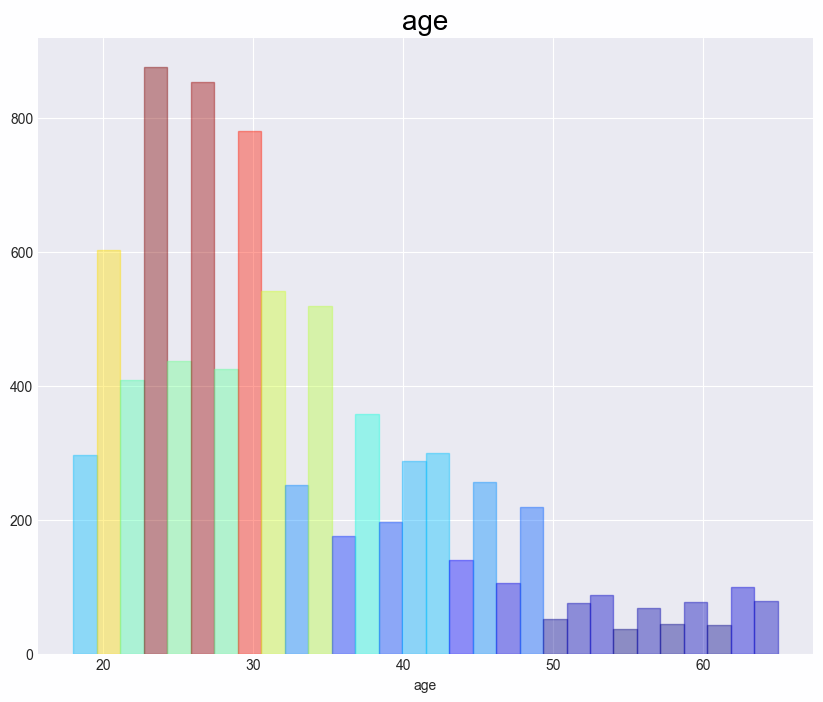


╔════════════════════════════════════════════════════════════╗
║                          INCOME_1                          ║
╚════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 52634.44059405941 ║
╚══════════════════════════════════════╝

╔═════════════════════════╗
║ Minumum value is : 1000 ║
╚═════════════════════════╝

╔═══════════════════════════╗
║ Maximum value is : 247600 ║
╚═══════════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


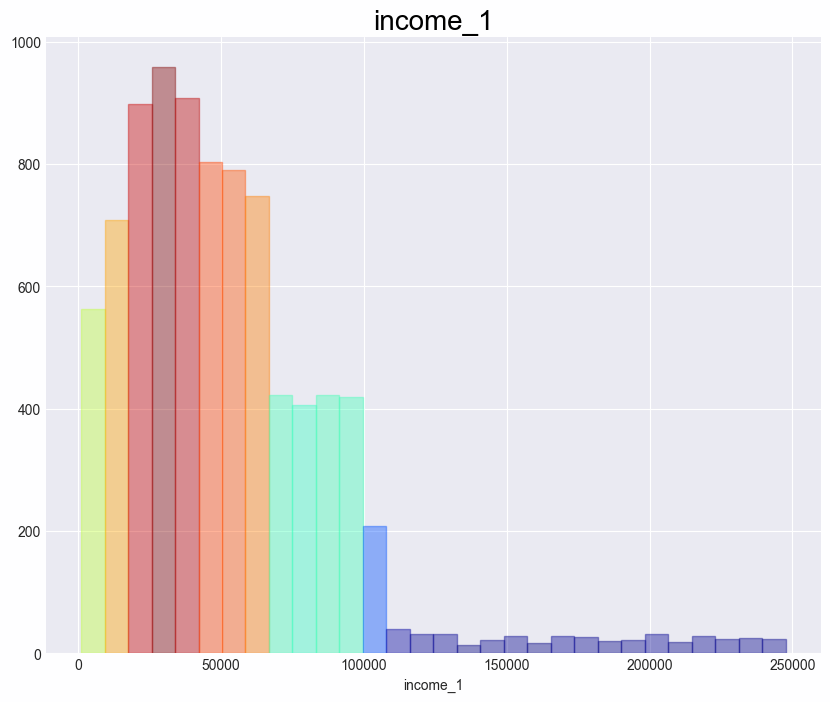


╔═══════════════════════════════════════════════════════════╗
║                          FB_FREQ                          ║
╚═══════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 1.7240386829380612 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


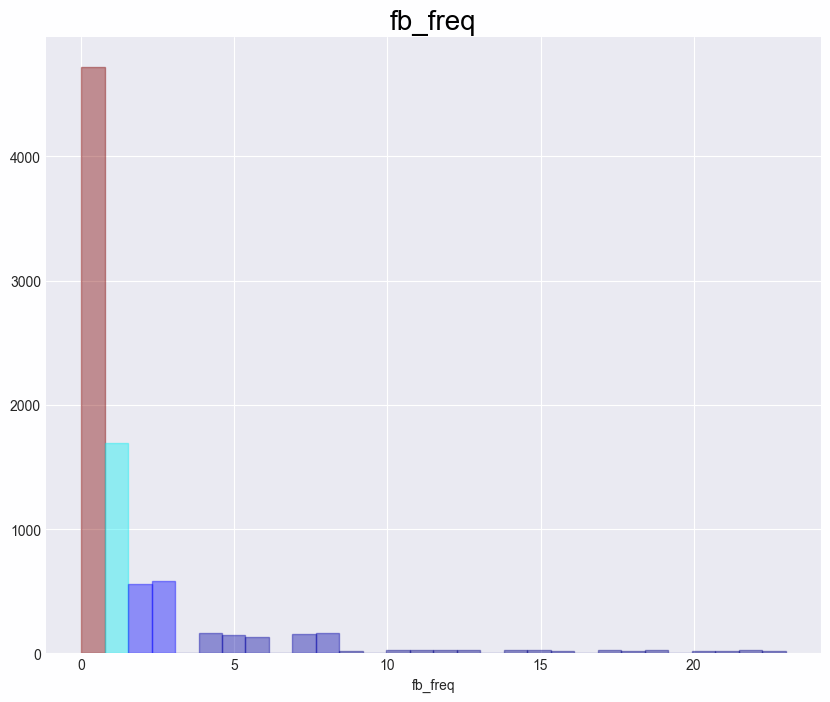


╔═══════════════════════════════════════════════════════════╗
║                          YT_FREQ                          ║
╚═══════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 3.215864609716786 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


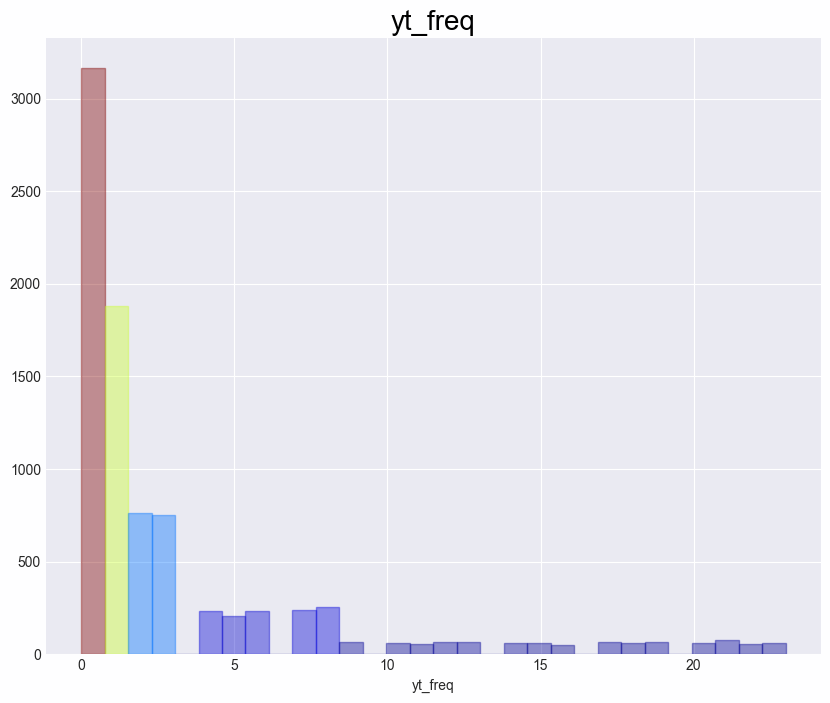


╔══════════════════════════════════════════════════════════════╗
║                          INSTA_FREQ                          ║
╚══════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════╗
║ Average value is : 4.96810960165784 ║
╚═════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


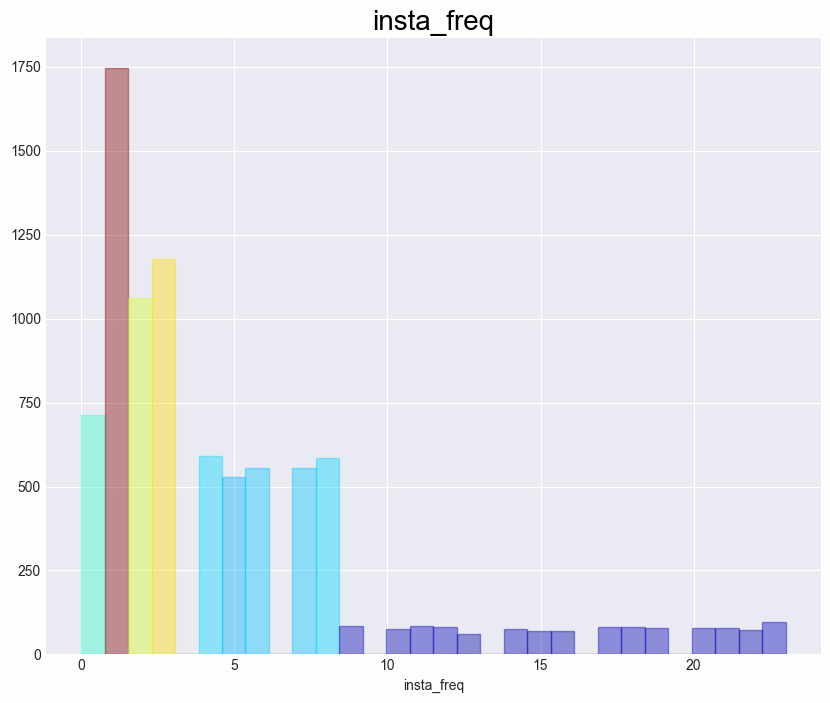


╔═════════════════════════════════════════════════════════════════════╗
║                          USE_LESS_THAN_2GB                          ║
╚═════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 4.2725074833064705 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


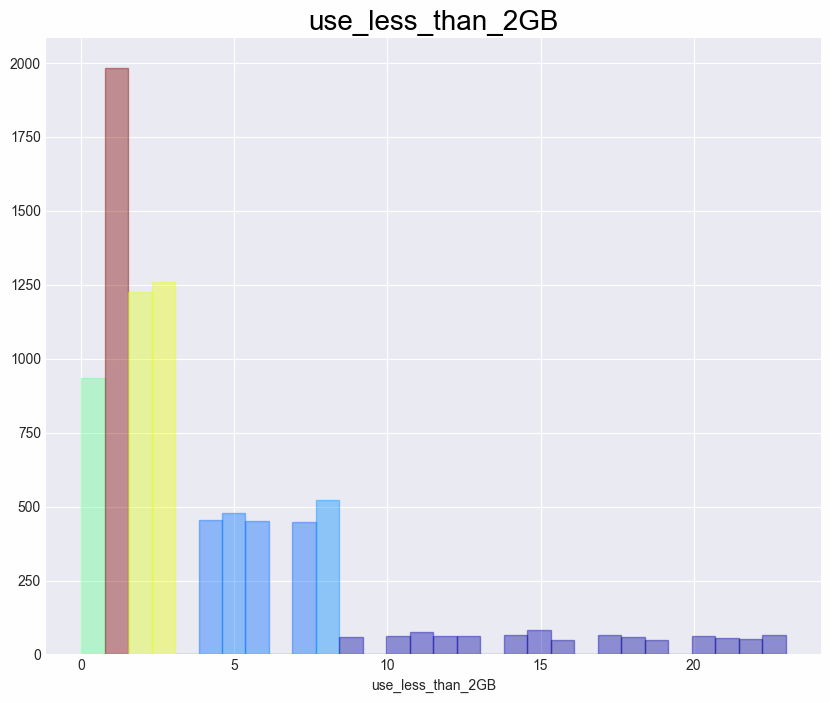


╔══════════════════════════════════════════════════════════════════╗
║                          USE_2GB_TO_4GB                          ║
╚══════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 1.6927239235551461 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔═══════════════════════╗
║ Maximum value is : 23 ║
╚═══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


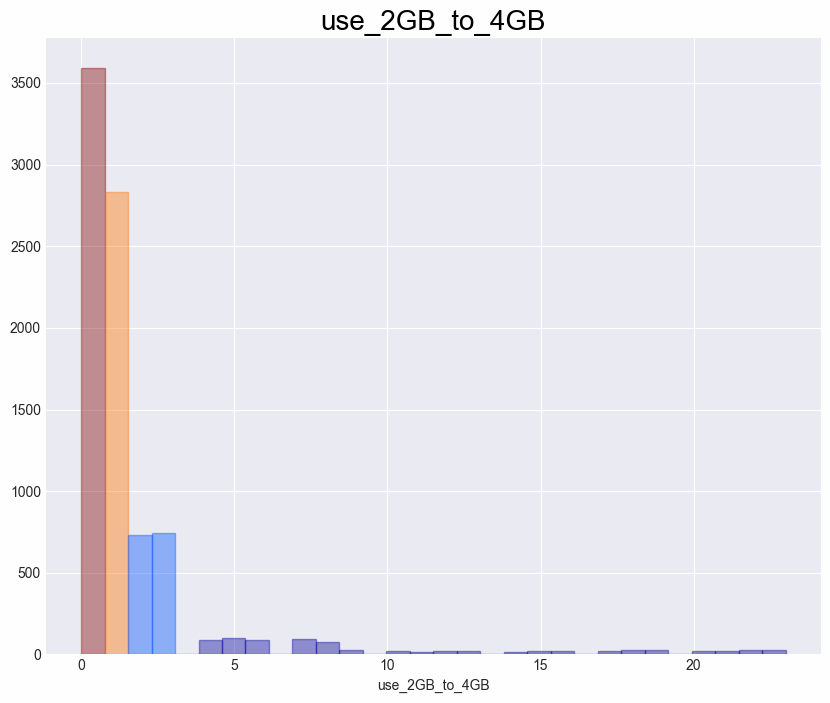


╔════════════════════════════════════════════════════════════╗
║                          CHILDREN                          ║
╚════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.7071148975362652 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 4 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


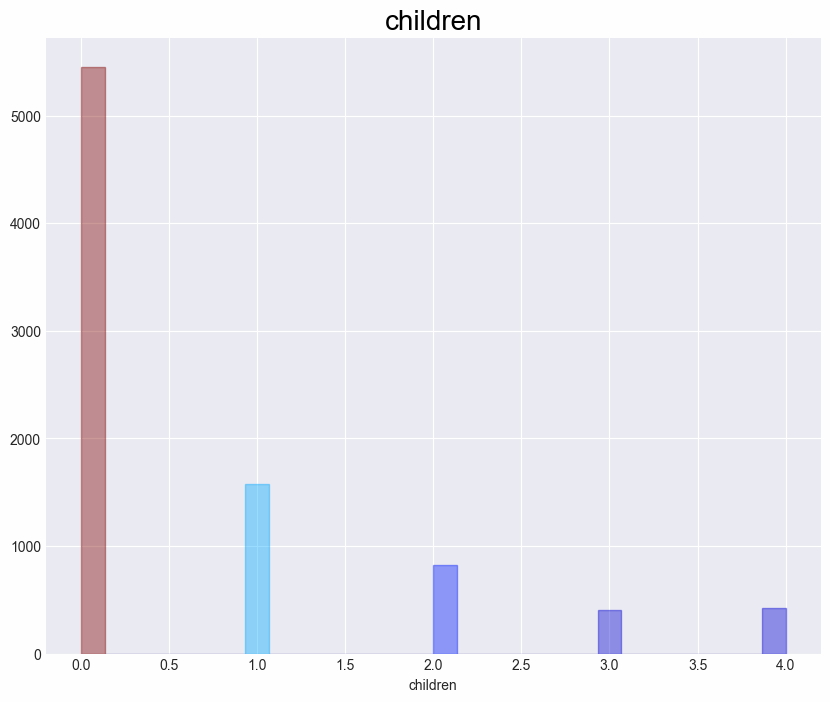


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_0                          ║
╚════════════════════════════════════════════════════════════════╝

╔════════════════════════╗
║ Average value is : 1.0 ║
╚════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 1 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


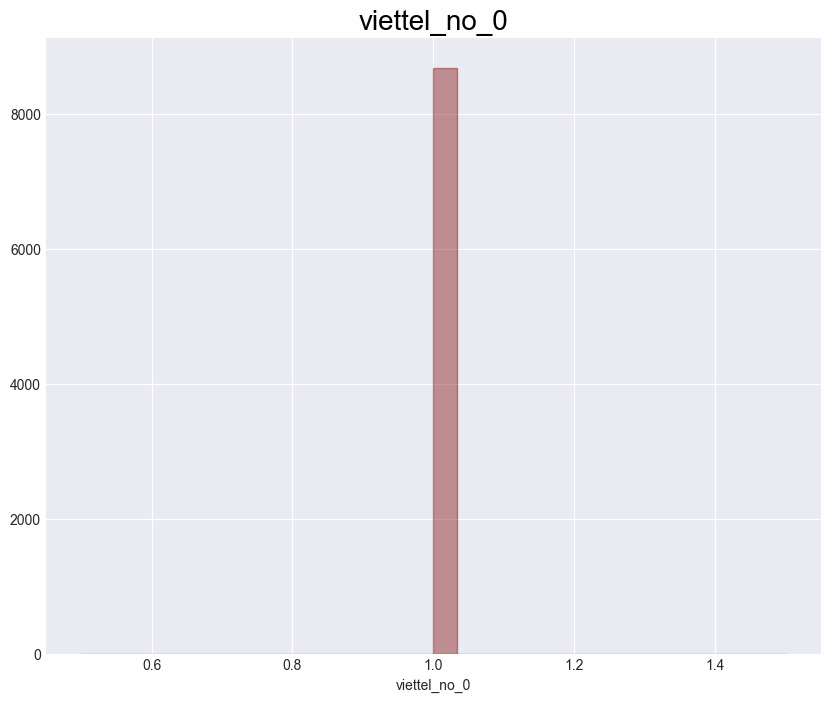


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_1                          ║
╚════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.5612479852636426 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located below mean ║
╚════════════════════════════════════════════╝
None


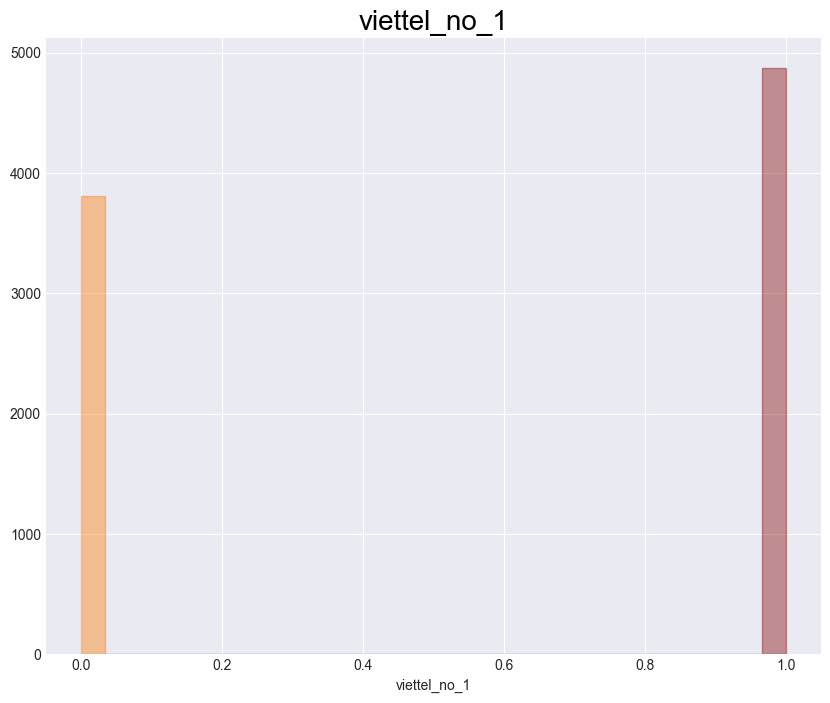


╔════════════════════════════════════════════════════════════════╗
║                          VIETTEL_NO_2                          ║
╚════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.11950264793921253 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


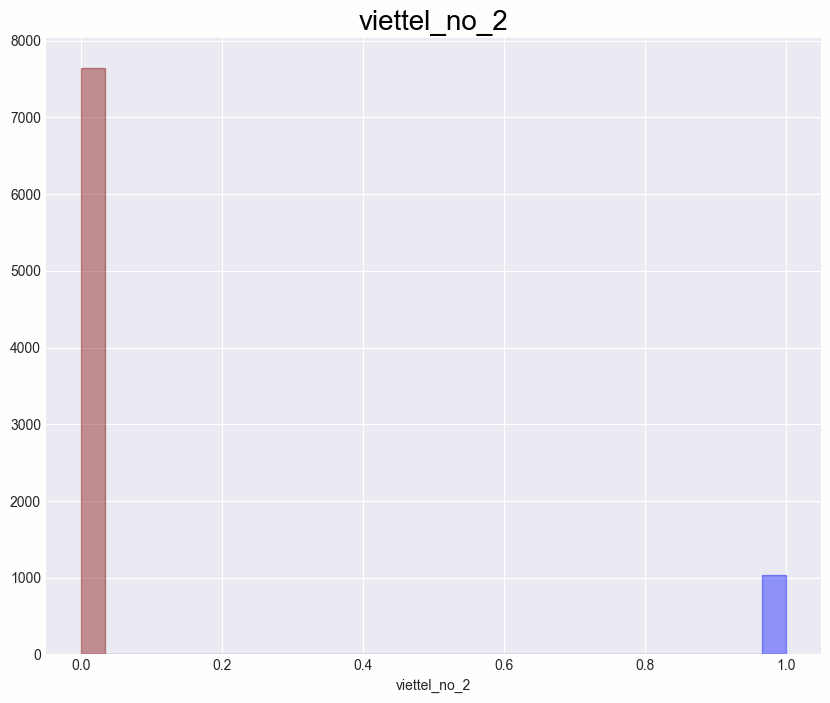


╔═════════════════════════════════════════════════════════╗
║                          SCORE                          ║
╚═════════════════════════════════════════════════════════╝

╔══════════════════════════════════════╗
║ Average value is : 5.112594980428275 ║
╚══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔════════════════════════╗
║ Maximum value is : 105 ║
╚════════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


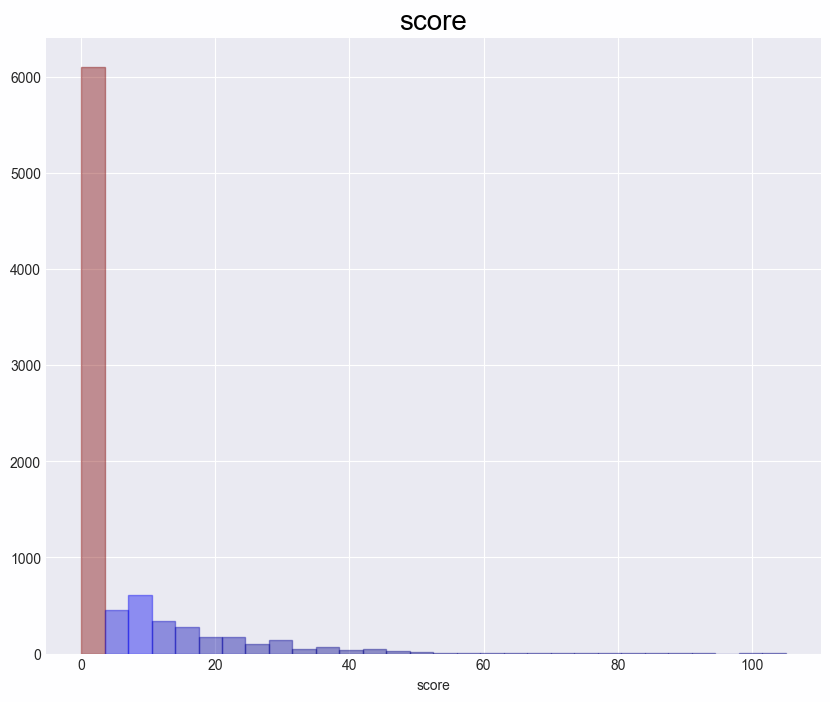


╔═════════════════════════════════════════════════════════════╗
║                          DIRECTION                          ║
╚═════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.21862767672116049 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


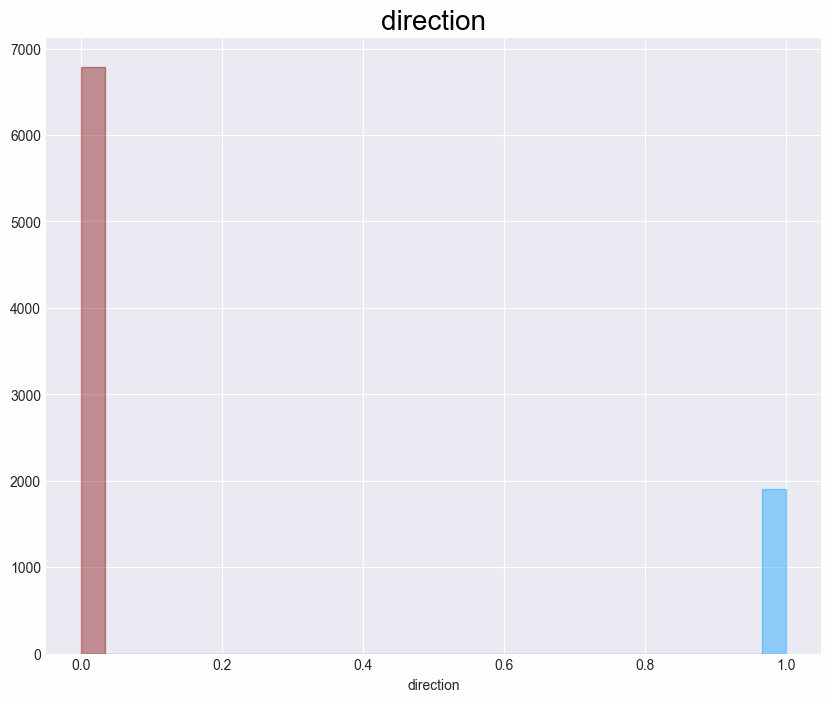


╔═════════════════════════════════════════════════════════════════╗
║                          DATASILVER_CR                          ║
╚═════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════╗
║ Average value is : 0.0838130324660373 ║
╚═══════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


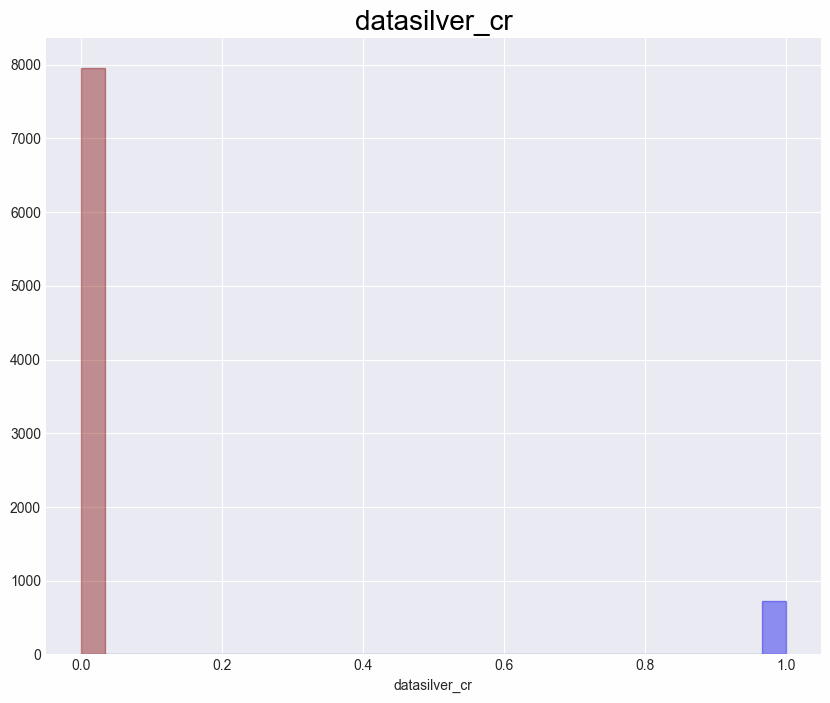


╔══════════════════════════════════════════════════════════════════════╗
║                          SOCIALMEDIAGOLD_CR                          ║
╚══════════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.08058945429426663 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


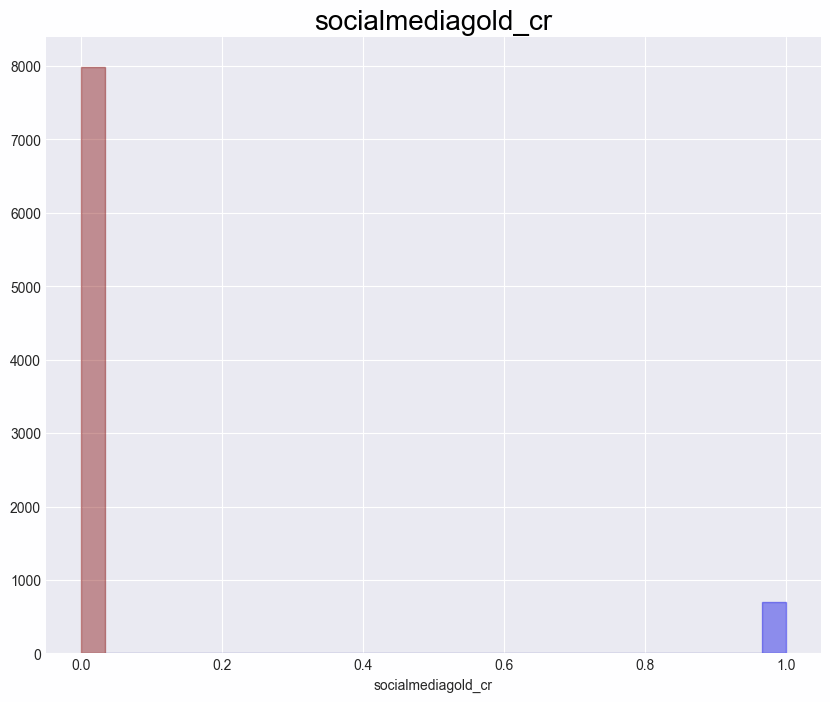


╔══════════════════════════════════════════════════════════════════╗
║                          SOCIALMEDIA_CR                          ║
╚══════════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.08669122726226111 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


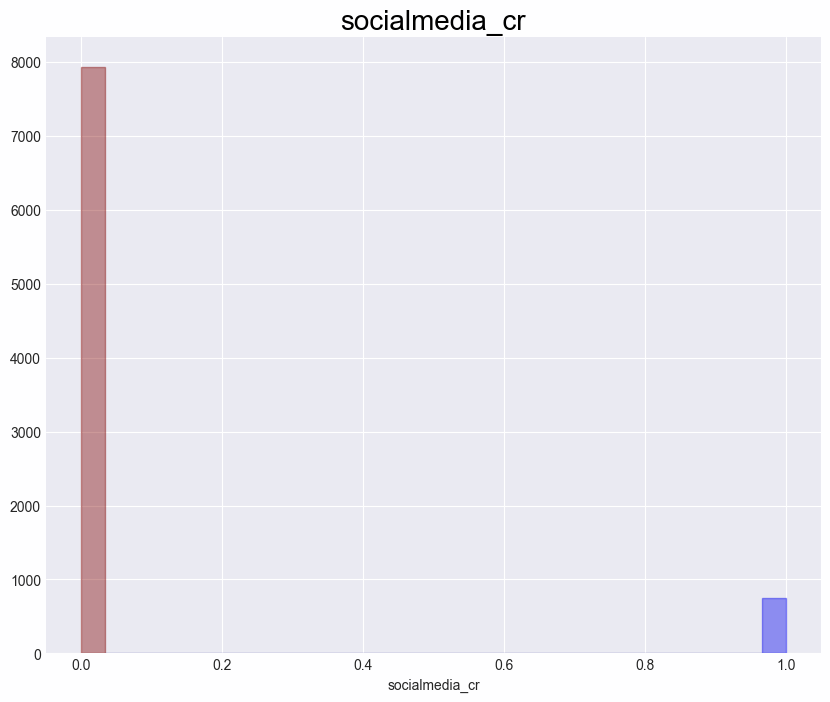


╔═══════════════════════════════════════════════════════════════╗
║                          DATACALL_CR                          ║
╚═══════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════╗
║ Average value is : 0.049159567119502645 ║
╚═════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


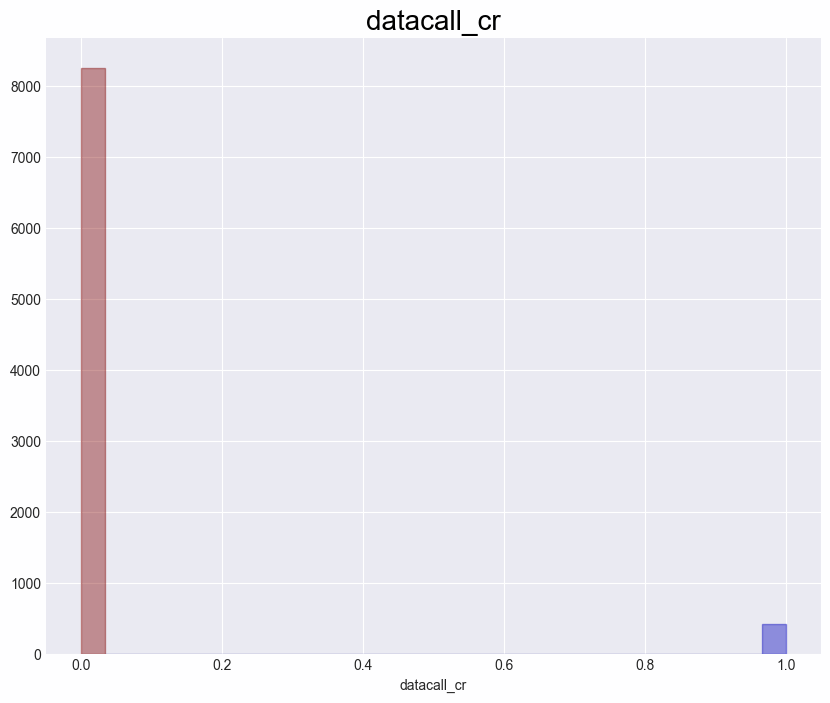


╔═══════════════════════════════════════════════════════════════╗
║                          DATAGOLD_CR                          ║
╚═══════════════════════════════════════════════════════════════╝

╔════════════════════════════════════════╗
║ Average value is : 0.04524522219663827 ║
╚════════════════════════════════════════╝

╔══════════════════════╗
║ Minumum value is : 0 ║
╚══════════════════════╝

╔══════════════════════╗
║ Maximum value is : 1 ║
╚══════════════════════╝

╔════════════════════════════════════════════╗
║ Normal distributed Data Located above mean ║
╚════════════════════════════════════════════╝
None


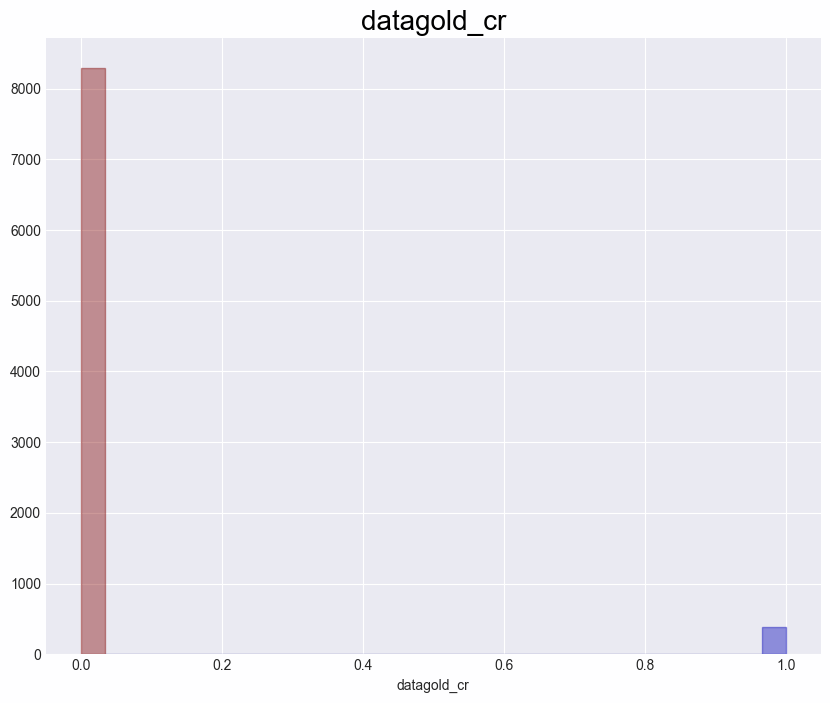

In [72]:
frame = EDA().run(features)

In [77]:
df

,gender,age,education,profession,income_1,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,...,datasilver,datagold,socialmedia,socialmediagold,datacall,datasilver_cr,socialmediagold_cr,socialmedia_cr,datacall_cr,datagold_cr
0,female,21,unknown,unemployed,39100,oceania,0,0,9,8,...,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0
1,other,22,unknown,unemployed,41000,europe,0,0,23,7,...,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0
2,female,24,unknown,unemployed,44300,asia,0,0,23,5,...,1.0,1.0,0.0,0.0,1.0,0,0,0,0,0
3,female,24,unknown,unemployed,44400,europe,0,0,21,7,...,1.0,0.0,0.0,1.0,0.0,0,1,0,0,0
4,female,25,unknown,unemployed,47826,americas,0,0,22,5,...,1.0,0.0,1.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567,male,26,grad,jobs,82000,europe,0,0,3,5,...,0.0,1.0,1.0,1.0,1.0,0,0,0,0,0
11568,male,26,grad,jobs,83900,asia,0,0,2,4,...,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0
11569,male,30,grad,jobs,76600,americas,0,0,3,7,...,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0
11570,male,30,grad,jobs,90760,oceania,0,0,2,7,...,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0
